# Sinkhorn for constrained OT problems

marion.chabrol@ensae.fr & suzie.grondin@ensae.fr

> Reference:  
> Tang, X., Rahmanian, H., Shavlovsky, M., Thekumparampil, K. K., Xiao, T., & Ying, L. (2024).  
> *A Sinkhorn-type Algorithm for Constrained Optimal Transport*. Submitted to ICLR 2025.  
> [PDF](https://openreview.net/forum?id=V5kCKFav9j) 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

# 1. Motivation and outline

We want to solve a regularized OT problem of the form:

$$
\min_{P: P1 = a, P^\top 1 = b, P \geq 0} \quad C \cdot P, \quad \text{such that } P \in \mathcal{S}
$$

Where $ a, b \in \mathbb{R}^n $ are the source and target distributions such that $ \sum_i a_i = \sum_j b_j = 1 $, and we define the constraint set $\mathcal{S} := \mathcal{I} \cap \mathcal{E}$ with $\mathcal{I}$ and $\mathcal{E}$ as below:

- Inequality constraints:  
  $$
  \mathcal{I} := \bigcap_{k=1}^{K} \{ P \mid D_k \cdot P \geq 0 \}
  $$
- Equality constraints:  
  $$
  \mathcal{E} := \bigcap_{l=1}^{L} \{ P \mid D_{l+K} \cdot P = 0 \}
  $$

To solve this problem efficiently, we follow the algorithmic framework introduced by **Tang et al. (2024)** in <i>A Sinkhorn-type Algorithm for Constrained Optimal Transport</i>, which generalizes the classical Sinkhorn algorithm to handle both equality and inequality constraints via dual updates.

The **iteration** combines three updates:

1. **Row update** (like classical Sinkhorn) to enforce $P\,1 \approx a$.  
2. **Column update** (like classical Sinkhorn) to enforce $P^\top\,1 \approx b$.  
3. **Constraint-dual update** to handle $D_k \cdot P \ge 0$ and $D_{K+\ell}\cdot P=0$.

We illustrate how to implement this in Python/JAX. First, we show the classical (unconstrained) Sinkhorn for comparison, then the constrained version. Finally, we compare their outputs on a toy example.



# 2. Basic imports and setup

In [2]:
import jax
import jax.numpy as jnp

import ott
from ott.geometry import pointcloud
from ott.geometry import geometry
from ott.solvers import linear

key = jax.random.PRNGKey(42)

In [3]:
def create_points(rng: jax.Array, n: int, m: int, d: int):
    rngs = jax.random.split(rng, 3)
    x = jax.random.normal(rngs[0], (n, d)) + 1
    y = jax.random.uniform(rngs[1], (m, d))
    return x, y

# 3. Classical Sinkhorn implementation

In [4]:
def demo_classical_sinkhorn(n=4, m=5, d=2, a=None, b=None, points=None):
    """
    Example usage of the classical_sinkhorn, with 2D points for source and target.
    We build a cost matrix from squared distances in 2D, run Sinkhorn, then plot points.

    Args:
        n (int): number of source points 
        m (int): number of target points 
        d (int): dimension of the space 
        a (array-like, optional): source distribution weights 
        b (array-like, optional): target distribution weights 
        points (tuple of arrays, optional): tuple (x, y) of point clouds to use instead
            of generating random ones

    Returns:
        geom (pointcloud.PointCloud): the geometry object containing cost and kernel information
        ot (linear.OTSolution): the result of the Sinkhorn algorithm
    """
    rng = jax.random.key(0)
    if points:
        x, y = points[0], points[1]
    else:
        x, y = create_points(rng, n=n, m=m, d=d)

    geom = pointcloud.PointCloud(x, y, epsilon=0.1)
    ot = linear.solve(geom, a=a, b=b)

    print(
        " Sinkhorn has converged: ",
        ot.converged,
        "\n",
        "Error upon last iteration: ",
        ot.errors[(ot.errors > -1)][-1],
        "\n",
        "Sinkhorn required ",
        jnp.sum(ot.errors > -1),
        " iterations to converge. \n",
        "Entropy regularized OT cost: ",
        ot.ent_reg_cost,
        "\n",
        "OT cost (without entropy): ",
        jnp.sum(ot.matrix * ot.geom.cost_matrix),
    )

    return geom, ot

In [5]:
classical_geom, classical_ot = demo_classical_sinkhorn()
P = classical_ot.matrix

print("Transport matrix:\n", P)
print("Row sums:", P.sum(axis=1))
print("Column sums:", P.sum(axis=0))

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.0009787977 
 Sinkhorn required  3  iterations to converge. 
 Entropy regularized OT cost:  1.1832969 
 OT cost (without entropy):  1.3980433
Transport matrix:
 [[1.6284798e-04 1.6212943e-01 4.4556905e-02 4.3150134e-02 9.4441361e-07]
 [1.9782817e-01 5.9102568e-08 1.6727718e-02 3.5443719e-02 3.2282344e-07]
 [2.9171215e-10 3.4618257e-12 4.6332435e-10 5.0489165e-02 1.9951086e-01]
 [2.1492471e-03 3.8057923e-02 1.3887717e-01 7.0914909e-02 7.6772449e-07]]
Row sums: [0.25000027 0.25       0.25000003 0.25      ]
Column sums: [0.20014028 0.20018741 0.20016178 0.19999792 0.1995129 ]


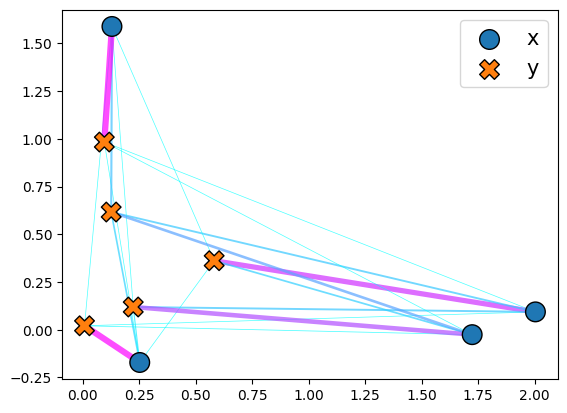

In [6]:
plott = ott.tools.plot.Plot()
_ = plott(classical_ot)


# 4. Constrained Sinkhorn implementation

We now incorporate additional constraints $ D_k \cdot P \geq 0 $ or $ = 0 $. 

For inequalities, we introduce slack variables $ \{s_k \geq 0\} $ so $ D_k \cdot P - s_k = 0 $. The iteration then becomes:

1. Row-scaling and column-scaling (as before).

2. Updating the dual variables $ \alpha_k $ for each $ D_k $ and the slack $ s_k $ for inequalities.

In [7]:
def constrained_sinkhorn(
    cost_matrix: jnp.ndarray,
    a: jnp.ndarray,
    b: jnp.ndarray,
    D_list: list,        
    eq_indices: list,   
    ineq_indices: list,  
    epsilon: float = 0.1,
    max_iter: int = 1000,
    tol: float = 1e-3,
    lr_dual: float = 1e-2,
    x_init=None,
    y_init=None,
    a_init=None
):
    """
    Implement regularized Sinkhorn for an OT problem with linear constraints
    
    Args:
        cost_matrix (jnp.ndarray): cost matrix of size (n,m)
        a (jnp.ndarray): Source distribution weights 
        b (jnp.ndarray): Target distribution weights 
        D_list (list of jnp.ndarray): list of matrix containing constraints (each D_k is of size (n,m))
        eq_indices (list): indices for which D_k · P = 0
        ineq_indices (list): indices for which D_k · P >= 0
        epsilon (float): weight for regularization
        max_iter (int): maximal number of iterations
        tol (float): tolerance on the constraints
        lr_dual (float): learning rate

    Return:
        x, y : dual potentials  
        alpha : dual multipliers for the constraints (D_k · P = 0 or ≥ 0)
        slack : vector of slack variables for the inequalities
        P : the resulting transport matrix
    """

    geom = geometry.Geometry(
        cost_matrix=cost_matrix,
        epsilon=epsilon 
    )

    # dimensions and init
    n, m = cost_matrix.shape[0], cost_matrix.shape[1]
    KplusL = len(D_list)
    K_ineq = len(ineq_indices)  

    x = jnp.zeros(n)
    y = jnp.zeros(m)

    alpha = jnp.zeros(KplusL)
    slack = jnp.ones(K_ineq)

    if x_init:
        x = x_init
    if y_init:
        y = y_init
    if a_init:
        alpha = a_init

    # main loop
    for it in range(max_iter):
        sum_D = jnp.zeros_like(cost_matrix)
        s_count = 0
        for k_idx in range(KplusL):
            if k_idx in eq_indices:
                sum_D = sum_D + alpha[k_idx] * D_list[k_idx]
            elif k_idx in ineq_indices:
                sum_D = sum_D + alpha[k_idx] * D_list[k_idx]
        
        cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
        K_ij = jnp.exp(cost_effective / epsilon - 1.0) 

        # row update
        row_sum = jnp.clip(K_ij.sum(axis=1), 1e-16, 1e16)
        x = x + epsilon * (jnp.log(a) - jnp.log(row_sum))

        cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
        K_ij = jnp.exp(cost_effective / epsilon - 1.0)

        # column update
        col_sum = jnp.clip(K_ij.sum(axis=0), 1e-16, 1e16)
        y = y + epsilon * (jnp.log(b) - jnp.log(col_sum))

        cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
        P_ij = jnp.exp(cost_effective / epsilon - 1.0)

        # constraint dual update step
        Dvals = jnp.array([jnp.sum(D_list[k] * P_ij) for k in range(KplusL)])
        new_alpha = alpha
        new_slack = slack
        s_count = 0

        for k_idx in range(KplusL):
            if k_idx in eq_indices:
                grad_k = Dvals[k_idx]
                new_alpha = new_alpha.at[k_idx].add(-lr_dual * grad_k)
            elif k_idx in ineq_indices:
                diff_k = Dvals[k_idx] - new_slack[s_count]
                grad_alpha = diff_k 
                new_alpha = new_alpha.at[k_idx].add(-lr_dual * grad_alpha)
                new_s_val = new_slack[s_count] - lr_dual * diff_k
                new_s_val = jnp.maximum(new_s_val, 1e-16)
                new_slack = new_slack.at[s_count].set(new_s_val)
                s_count += 1
        
        alpha = new_alpha
        slack = new_slack

        # check convergence
        row_err = jnp.linalg.norm(jnp.sum(P_ij, axis=1) - a, 1)
        col_err = jnp.linalg.norm(jnp.sum(P_ij, axis=0) - b, 1)

        if row_err < tol and col_err < tol:
            print(f"=== Algo converged in {it} iterations")
            break

    # final P
    cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
    P_final = jnp.exp(cost_effective / epsilon - 1.0)

    return x, y, alpha, slack, P_final


In [8]:
def demo_constrained_sinkhorn(n=4, m=5, d=2, a=None, b=None, points=None, D_list=None):
    """
    Runs constrained Sinkhorn with 2D data
    """
    rng = jax.random.key(0)
    if points:
        x, y = points[0], points[1]
    else:
        x, y = create_points(rng, n=n, m=m, d=d)

    geom = pointcloud.PointCloud(x, y, epsilon=0.1)

    if a is not None:
        a=a
    else:
        a = jnp.ones(n) / n
    if b is not None:
        b=b
    else:
        b = jnp.ones(m) / m

    C = geom.cost_matrix

    # define constraints: one inequality (>= 0) and one equality (= 0)
    D1 = jnp.ones((n, m)) 
    D2 = 2*jnp.eye(n, m) 
    if D_list:
        D1, D2 = D_list[0], D_list[1]
    D_list = [D1, D2]
    ineq_indices = [0]  # index of D1
    eq_indices   = [1]  # index of D2

    # Run constrained Sinkhorn
    x_c, y_c, alpha_c, s_c, P_c = constrained_sinkhorn(
        C, a, b, D_list, eq_indices, ineq_indices,
        epsilon=1/10, max_iter=300, tol=1e-7, lr_dual=0.05 
    )

    return geom, alpha_c, s_c, P_c, D_list

In [9]:
geom_c, alpha_c, s_c, P_c, D_list = demo_constrained_sinkhorn()

print("Constrained Sinkhorn solution:")
print("Transport matrix:\n", P_c)
print("Row sums:", P_c.sum(axis=1))
print("Column sums:", P_c.sum(axis=0))
print("D1.P =>", (D_list[0] * P_c).sum(), "slack =>", s_c[0])
print("D2.P =>", (D_list[1] * P_c).sum(), "(should be ~0)")


Constrained Sinkhorn solution:
Transport matrix:
 [[1.3012291e-06 1.2981842e-01 2.3744993e-02 9.6430793e-02 2.1354886e-06]
 [1.9260085e-01 1.6481501e-10 5.8069918e-03 5.1597673e-02 4.7550728e-07]
 [1.9327757e-10 1.2288363e-12 5.8521466e-13 5.0020218e-02 1.9999342e-01]
 [7.3978053e-03 7.0181578e-02 1.7044802e-01 1.9513414e-03 3.9980159e-06]]
Row sums: [0.24999765 0.250006   0.25001365 0.24998274]
Column sums: [0.19999994 0.2        0.2        0.20000002 0.20000002]
D1.P => 1.0 slack => 1.0
D2.P => 0.0039052856 (should be ~0)


In [10]:
def visualize_transport_plan(x, y, P, title="Optimal transport plan visualization"):
    """
    Visualizes the transport plan between two point clouds

    Args:
        x (array-like): Source point cloud of shape (n, d)
        y (array-like): Target point cloud of shape (m, d)
        P (array-like): Transport matrix of shape (n, m), where P[i, j] indicates the amount 
                        of mass transported from point x[i] to point y[j]
    """

    n, m = P.shape

    # normalize transport matrix for visualization
    max_value = np.max(P)
    normalized_transport = P / max_value if max_value > 0 else P

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    plt.subplots_adjust(wspace=0.4) 

    # transport flow plot 
    ax1 = axes[0]
    ax1.scatter(x[:, 0], x[:, 1], color='blue', label="Source Distribution", alpha=0.8, edgecolors='k', s=100)
    ax1.scatter(y[:, 0], y[:, 1], color='red', label="Target Distribution", alpha=0.8, edgecolors='k', s=100, marker="s")

    for i in range(n):
        for j in range(m):
            if P[i, j] > 0.001:  # only plot significant transport values
                ax1.plot([x[i, 0], y[j, 0]], [x[i, 1], y[j, 1]], 'gray',
                         alpha=0.6, linewidth=5 * normalized_transport[i, j])

    for i, (xi, yi) in enumerate(x):
        ax1.text(xi + 0.2, yi, f"S{i}", fontsize=12, color='blue')

    for j, (xj, yj) in enumerate(y):
        ax1.text(xj + 0.2, yj, f"T{j}", fontsize=12, color='red')

    ax1.set_xlabel("X-coordinate")
    ax1.set_ylabel("Y-coordinate")
    ax1.set_title(title)
    ax1.legend()

    # heatmap of transport plan 
    ax2 = axes[1]
    sns.heatmap(P, annot=True, fmt=".2f", cmap="Purples", linewidths=0.5, ax=ax2)

    ax2.set_xlabel("Target Distribution Index")
    ax2.set_ylabel("Source Distribution Index")
    ax2.set_title(title)

    plt.show()

In [11]:
def visualize_D_as_heatmap(D, title="Matrix D"):
    plt.figure(figsize=(4,4))
    plt.imshow(D, cmap="viridis", aspect="auto") 
    plt.colorbar(label="Value of constraint D(i,j)")
    plt.title(title)
    plt.xlabel("Index j (target)")
    plt.ylabel("Index i (source)")
    plt.show()

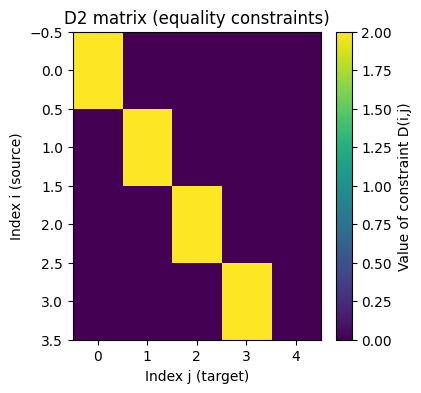

In [12]:
#constraints : sum of yellow cells must be = 0
visualize_D_as_heatmap(D_list[1], title="D2 matrix (equality constraints)")

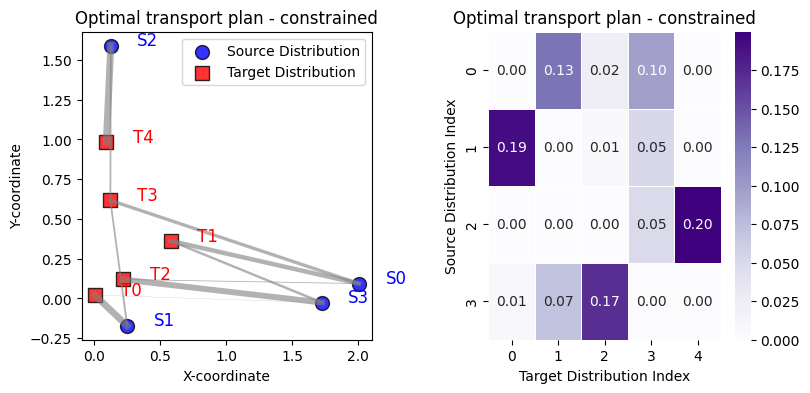

In [13]:
visualize_transport_plan(geom_c.x, geom_c.y, P_c, title="Optimal transport plan - constrained")

<div style="
    border-left: 6px solid #1976d2;
    background-color: #e3f2fd;
    padding: 16px;
    border-radius: 6px;
    font-size: 15px;
    color: #212121;
    max-width: 100%;
    line-height: 1.6;
    word-wrap: break-word;
    box-sizing: border-box; /* Ajoutez cette ligne */
    overflow-wrap: break-word; /* Ajoutez cette ligne */
">

The first figure shows the constraint matrix $ D2 \in \mathbb{R}^{4 \times 5} $, where the yellow diagonal highlights entries that are constrained. These values correspond to positions in the transport matrix $ P $ where the transported mass must be **zero**. This is confirmed in the second figure: the entries in $ P $ that align with the yellow diagonal of $ D2 $ are indeed zero, demonstrating that the constraints have been respected.

In the next section, we compare this result with the classical Sinkhorn algorithm, which does **not** enforce such constraints. This will allow us to observe the effect of incorporating constraints in optimal transport.

</div>


# 5. Comparison

In [14]:
def compare_classical_and_constrained(n=4 ,m=5 ,d=2, a=None, b=None, points=None, D_list=None):

    rng = jax.random.key(0)
    if points:
        x, y = points[0], points[1]
    else:
        x, y = create_points(rng, n=n, m=m, d=d)

    geom = pointcloud.PointCloud(x, y, epsilon=0.1)

    if a is not None:
        a=a
    else:
        a = jnp.ones(n) / n
    if b is not None:
        b=b
    else:
        b = jnp.ones(m) / m

    C = geom.cost_matrix
    
    # suppose we have 1 ineq D, 1 eq D
    D1 = jnp.ones((n,m))
    D2 = 2*jnp.eye(n,m)
    if D_list:
        D1, D2 = D_list[0], D_list[1]
    D_list = [D1, D2]

    ineq_indices = [0]
    eq_indices   = [1]
    
    # classical 
    ot = linear.solve(geom)
    P_o = ot.matrix

    # constrained 
    x_c, y_c, alpha_c, s_c, P_c = constrained_sinkhorn(
        C, a, b, D_list, eq_indices, ineq_indices,
        epsilon=1/10, max_iter=300, tol=1e-5, lr_dual=0.01 
    )

    visualize_transport_plan(geom.x, geom.y, P_o, title="Optimal transport plan -non constrained-")
    visualize_D_as_heatmap(D_list[1], title="D2 matrix (equality constraints)")
    visualize_transport_plan(geom.x, geom.y, P_c, title="Optimal transport plan -constrained-")
    
    print("CLASSICAL SINKHORN P:\n", P_o)
    print("Row sums:", P_o.sum(axis=1))
    print("Column sums:", P_o.sum(axis=0))
    print("Cost:", (C*P_o).sum())
    
    print("\nCONSTRAINED SINKHORN P:\n", P_c)
    print("Row sums:", P_c.sum(axis=1))
    print("Column sums:", P_c.sum(axis=0))
    print("Cost:", (C*P_c).sum())
    print("Check D1.P =>", (D1*P_c).sum(), "  Slack =>", s_c[0])
    print("Check D2.P =>", (D2*P_c).sum(), "  (should be ~0)")


=== Algo converged in 50 iterations


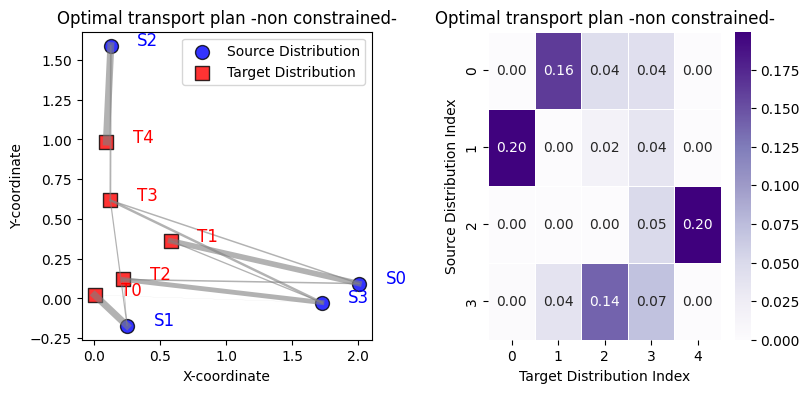

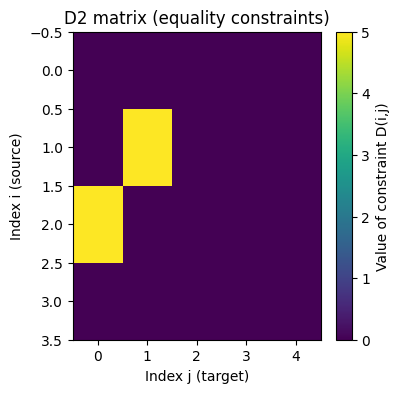

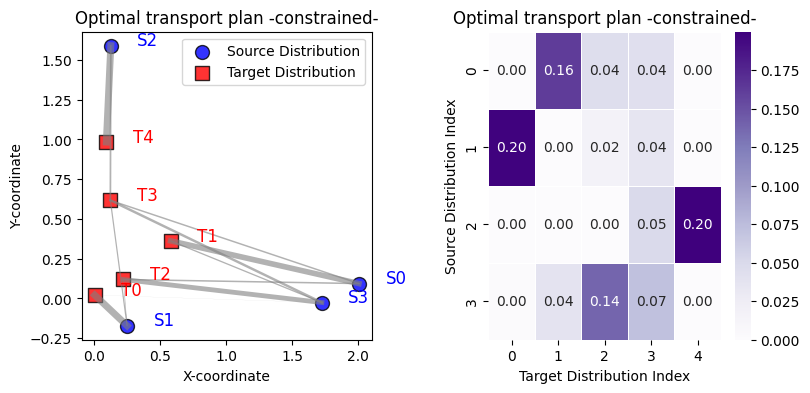

CLASSICAL SINKHORN P:
 [[1.6284798e-04 1.6212943e-01 4.4556905e-02 4.3150134e-02 9.4441361e-07]
 [1.9782817e-01 5.9102568e-08 1.6727718e-02 3.5443719e-02 3.2282344e-07]
 [2.9171215e-10 3.4618257e-12 4.6332435e-10 5.0489165e-02 1.9951086e-01]
 [2.1492471e-03 3.8057923e-02 1.3887717e-01 7.0914909e-02 7.6772449e-07]]
Row sums: [0.25000027 0.25       0.25000003 0.25      ]
Column sums: [0.20014028 0.20018741 0.20016178 0.19999792 0.1995129 ]
Cost: 1.3980433

CONSTRAINED SINKHORN P:
 [[1.6267879e-04 1.6199695e-01 4.4538997e-02 4.3299399e-02 9.5916425e-07]
 [1.9769165e-01 5.8637596e-08 1.6726824e-02 3.5578709e-02 3.2798033e-07]
 [2.8549921e-10 3.4141147e-12 4.5712883e-10 5.0006390e-02 1.9999795e-01]
 [2.1456662e-03 3.8002938e-02 1.3873416e-01 7.1115509e-02 7.7922562e-07]]
Row sums: [0.24999899 0.24999757 0.25000435 0.24999905]
Column sums: [0.19999999 0.19999994 0.19999999 0.2        0.2       ]
Cost: 1.3982509
Check D1.P => 0.9999999   Slack => 1.0
Check D2.P => 2.946155e-07   (should be ~0

In [15]:
D1 = jnp.ones((4,5))
D2 = 5*jnp.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=jnp.float32)
compare_classical_and_constrained(D_list=[D1, D2])

<div style="
    border-left: 6px solid #1976d2;
    background-color: #e3f2fd;
    padding: 16px;
    border-radius: 6px;
    font-size: 15px;
    color: #212121;
    max-width: 100%;
    line-height: 1.6;
    word-wrap: break-word;
    box-sizing: border-box; /* Ajoutez cette ligne */
    overflow-wrap: break-word; /* Ajoutez cette ligne */
">

The comparison between the classical and constrained Sinkhorn algorithms reveals the impact of enforcing linear constraints in optimal transport. In the classical case (top figures and matrix), some mass is transported through forbidden entries (see <strong>D2</strong>).<br><br>

In contrast, the constrained Sinkhorn solution (bottom figures and matrix) respects the constraints, as shown by zero values in the forbidden positions of <strong>P</strong> and the validation check <strong>D2 · P ≈ 0</strong>. However, this enforcement comes at the cost of a slightly higher transport cost (1.614 vs. 1.428), due to constraint satisfaction.

</div>


# 6. Acceleration techniques 

## **Entropy Regularization Scheduling (ERS)**  

Entropy regularization $\eta$ plays a crucial role in the iteration complexity of the Sinkhorn algorithm. Poor tuning can either slow down convergence or affect the precision of optimal transport.  

### **Acceleration with Entropy Regularization Scheduling (ERS)**  
To enhance efficiency, we use the **doubling entropy regularization scheduling** technique proposed by **Chen et al. (2023)**.  

Given a target regularization value $\eta_{\text{final}}$ , we start with an initial value $\eta_{\text{init}}$ and compute the number of regularization levels as:  

$$
N_{\eta} = \lceil \log_2(\eta_{\text{final}} / \eta_{\text{init}}) \rceil
$$

We then define a sequence of **successively doubling regularization values**:

$$
\eta_0, \eta_1, \dots, \eta_{N_{\eta}}
$$

where:

- $ \eta_0 = \eta_{\text{init}} $
- $ \eta_{i} = 2\eta_{i-1} $ for $ i = 1, \dots, N_{\eta} - 1 $
- $ \eta_{N_{\eta}}, \dots, \eta_{max\_iter}$  $= \eta_{\text{final}} $

In [16]:
def constrained_sinkhorn_ers(
    cost_matrix,          
    a,                   
    b,                   
    D_list=None,          
    eq_indices=None,      
    ineq_indices=None,   
    eta=None,             
    eta_init=None,        
    eta_final=None,       
    max_iter=1000,
    tol=1e-9,
    lr_dual=1e-2,
    x_init=None,
    y_init=None,
    a_init=None 
):
    """
    Implement regularized Sinkhorn for an OT problem with linear constraints with ERS (doubling)
    
    Args:
        cost_matrix (jnp.ndarray): cost matrix of size (n,m)
        a (jnp.ndarray): Source distribution weights 
        b (jnp.ndarray): Target distribution weights 
        D_list (list of jnp.ndarray): list of matrix containing constraints (each D_k is of size (n,m))
        eq_indices (list): indices for which D_k · P = 0
        ineq_indices (list): indices for which D_k · P >= 0
        eta: inverse of the weight for regularization
        eta_init: inverse of the initial weight for regularization
        eta_final: inverse of the final weight for regularization
        max_iter (int): maximal number of iterations
        tol (float): tolerance on the constraints
        lr_dual (float): learning rate

    Return:
        xs, ys: dual potentials over the iterations
        alphas: : dual multipliers for the constraints (D_k · P = 0 or ≥ 0) over the iterations
        jnp.array(iters): number of iterations 
        jnp.array(costs): cost over the iterations
        jnp.array(violations): violations over the iterations 
        jnp.array(times): elapsed time 
        Ps: the resulting transport matrix over the iterations
        jnp.array(etas_list): eta over the iterations
    """
    
    if D_list is None:
        D_list = []
    if eq_indices is None:
        eq_indices = []
    if ineq_indices is None:
        ineq_indices = []
    
   
    entropy_reg_sched = eta_init is not None and eta_final is not None
    

    if entropy_reg_sched:
        epsilon = 1/eta_init
        N_eta = math.ceil(math.log2(eta_final / eta_init))
    else:
        if eta is None:
            eta = 1e-2  
        epsilon = 1/eta
    
    
    iters = []
    costs = []
    violations = []
    times = []
    Ps = []
    etas_list = []
    xs = []
    ys=[]
    alphas=[]
    
    t0 = time.time()
    

    n, m = cost_matrix.shape[0], cost_matrix.shape[1]
    KplusL = len(D_list) 
    K_ineq = len(ineq_indices)  

    
    x = jnp.zeros(n) if x_init is None else x_init
    y = jnp.zeros(m) if y_init is None else y_init
    alpha = jnp.zeros(KplusL) if a_init is None else a_init
    slack = jnp.ones(K_ineq)  

    for it in range(1, max_iter + 1):
        if entropy_reg_sched:
            if it <= N_eta:
                current_eta = eta_init * (2 ** (it - 1))
                current_eta = min(current_eta, eta_final)
            else:
                current_eta = eta_final
            epsilon = 1/current_eta
            etas_list.append(float(current_eta))
        
        sum_D = jnp.zeros_like(cost_matrix)
        s_count = 0
        for k_idx in range(KplusL):
            if k_idx in eq_indices:
                sum_D = sum_D + alpha[k_idx] * D_list[k_idx]
            elif k_idx in ineq_indices:
                sum_D = sum_D + alpha[k_idx] * D_list[k_idx]
        
        cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
        K_ij = jnp.exp(cost_effective / epsilon - 1.0)

        row_sum = jnp.clip(K_ij.sum(axis=1), 1e-16, 1e16)
        x = x + epsilon * (jnp.log(a) - jnp.log(row_sum))

        cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
        K_ij = jnp.exp(cost_effective / epsilon - 1.0)

        col_sum = jnp.clip(K_ij.sum(axis=0), 1e-16, 1e16)
        y = y + epsilon * (jnp.log(b) - jnp.log(col_sum))

        cost_effective = -cost_matrix + sum_D + x[:, None] + y[None, :]
        P_ij = jnp.exp(cost_effective / epsilon - 1.0)

        cost = jnp.sum(P_ij * cost_matrix)
        costs.append(float(cost))
        
        row_err = jnp.linalg.norm(jnp.sum(P_ij, axis=1) - a, 1)
        col_err = jnp.linalg.norm(jnp.sum(P_ij, axis=0) - b, 1)
        viol = row_err + col_err
        violations.append(float(viol))
        
        times.append(time.time() - t0)
        Ps.append(P_ij)
        iters.append(it)

        xs.append(x)
        ys.append(y)
        

        if KplusL > 0:
            Dvals = jnp.array([jnp.sum(D_list[k] * P_ij) for k in range(KplusL)])
            
            new_alpha = alpha
            new_slack = slack
            s_count = 0

            for k_idx in range(KplusL):
                if k_idx in eq_indices:
                    grad_k = Dvals[k_idx]
                    new_alpha = new_alpha.at[k_idx].add(-lr_dual * grad_k)
                elif k_idx in ineq_indices:
                    diff_k = Dvals[k_idx] - new_slack[s_count]
                    grad_alpha = diff_k
                    new_alpha = new_alpha.at[k_idx].add(-lr_dual * grad_alpha)
                    new_s_val = new_slack[s_count] - lr_dual * diff_k
                    new_s_val = jnp.maximum(new_s_val, 1e-16)
                    new_slack = new_slack.at[s_count].set(new_s_val)
                    s_count += 1

            alpha = new_alpha
            slack = new_slack

        alphas.append(alpha)

        if viol < tol:
            print(f"=== Algo converged in {it} iterations")
            break

    if entropy_reg_sched:
        return (
            xs, 
            ys,
            alphas,
            jnp.array(iters), 
            jnp.array(costs), 
            jnp.array(violations), 
            jnp.array(times), 
            Ps, 
            jnp.array(etas_list)
        )
    else:
        return (
            xs, 
            ys,
            alphas,
            jnp.array(iters), 
            jnp.array(costs), 
            jnp.array(violations), 
            jnp.array(times), 
            Ps
        )

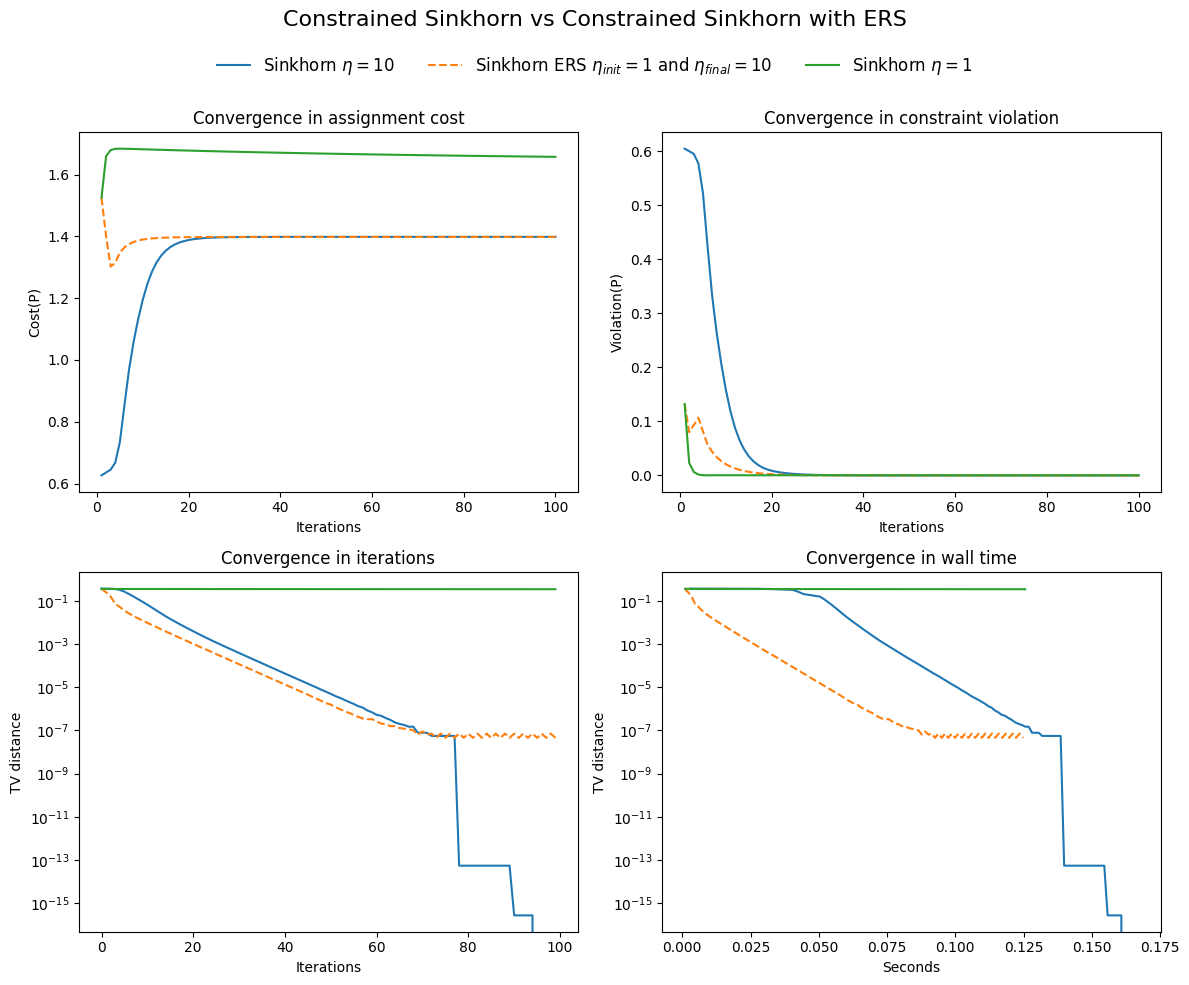

<Figure size 640x480 with 0 Axes>

In [17]:
rng = jax.random.key(0)
n=4
m=5
d=2
x, y = create_points(rng, n=n, m=m, d=d)
geom = pointcloud.PointCloud(x, y, epsilon=0.1)
C = geom.cost_matrix
D1 = jnp.ones((4,5))
D2 = 5*jnp.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=jnp.float32)
D_list = [D1, D2]
ineq_indices = [0]
eq_indices   = [1]
a = jnp.ones(n) / n
b = jnp.ones(m) / m

_, _, _, it_sk, cost_sk, viol_sk, time_sk, Ps_sk = constrained_sinkhorn_ers(C, a, b, D_list=D_list, eq_indices=eq_indices, ineq_indices=ineq_indices, eta=10, max_iter=100)
_, _, _, it_sk_bis, cost_sk_bis, viol_sk_bis, time_sk_bis, Ps_sk_bis = constrained_sinkhorn_ers(C, a, b,D_list=D_list, eq_indices=eq_indices, ineq_indices=ineq_indices, eta=1, max_iter=100)
_, _, _, it_ers, cost_ers, viol_ers, time_ers, Ps_ers, etas = constrained_sinkhorn_ers(C, a, b, D_list=D_list, eq_indices=eq_indices, ineq_indices=ineq_indices, eta_init=1, eta_final=10, max_iter=100)

n, m = C.shape[0], C.shape[1]

P_ref = Ps_sk[-1]

def tv_distances(Ps, Pref):
    return np.array([0.5 * np.sum(np.abs(P - Pref)) for P in Ps])

tv_sk = tv_distances(Ps_sk, P_ref)
tv_sk_bis = tv_distances(Ps_sk_bis, P_ref)
tv_ers = tv_distances(Ps_ers, P_ref)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))


axes[0,0].plot(it_sk, cost_sk, label='Sinkhorn $\\eta=10$')
axes[0,0].plot(it_ers, cost_ers, '--', label='Sinkhorn ERS $\\eta_{init}=1$ and $\\eta_{final}=10$')
axes[0,0].plot(it_sk_bis, cost_sk_bis, label='Sinkhorn $\\eta=1$')
axes[0,0].set_xlabel("Iterations"); axes[0,0].set_ylabel("Cost(P)")
axes[0,0].set_title("Convergence in assignment cost")


axes[0,1].plot(it_sk, viol_sk, label='Sinkhorn $\\eta=10$')
axes[0,1].plot(it_ers, viol_ers, '--', label='Sinkhorn ERS $\\eta_{init}=1$ and $\\eta_{final}=10$')
axes[0,1].plot(it_sk_bis, viol_sk_bis, label='Sinkhorn $\\eta=1$')
axes[0,1].set_xlabel("Iterations"); axes[0,1].set_ylabel("Violation(P)")
axes[0,1].set_title("Convergence in constraint violation")


axes[1,0].semilogy(range(len(tv_sk)), tv_sk, label='Sinkhorn $\\eta=10$')
axes[1,0].semilogy(range(len(tv_ers)), tv_ers, '--', label='Sinkhorn ERS $\\eta_{init}=1$ and $\\eta_{final}=10$')
axes[1,0].semilogy(range(len(tv_sk_bis)), tv_sk_bis, label='Sinkhorn $\\eta=1$')
axes[1,0].set_xlabel("Iterations"); axes[1,0].set_ylabel("TV distance")
axes[1,0].set_title("Convergence in iterations")


axes[1,1].semilogy(time_sk, tv_sk, label='Sinkhorn $\\eta=10$')
axes[1,1].semilogy(time_ers, tv_ers, '--', label='Sinkhorn ERS $\\eta_{init}=1$ and $\\eta_{final}=10$')
axes[1,1].semilogy(time_sk_bis, tv_sk_bis, label='Sinkhorn $\\eta=1$')
axes[1,1].set_xlabel("Seconds"); axes[1,1].set_ylabel("TV distance")
axes[1,1].set_title("Convergence in wall time")

fig.suptitle("Constrained Sinkhorn vs Constrained Sinkhorn with ERS", fontsize=16)

all_handles_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
handles = sum([hl[0] for hl in all_handles_labels], [])
labels  = sum([hl[1] for hl in all_handles_labels], [])

by_label = dict(zip(labels, handles))

fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='upper center',
    bbox_to_anchor=(0.5, 0.95),
    ncol=3,
    frameon=False,
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


plt.tight_layout()
plt.show()


<div style="
    border-left: 6px solid #1976d2;
    background-color: #e3f2fd;
    padding: 16px;
    border-radius: 6px;
    font-size: 15px;
    color: #212121;
    max-width: 100%;
    line-height: 1.6;
    word-wrap: break-word;
    box-sizing: border-box; /* Ajoutez cette ligne */
    overflow-wrap: break-word; /* Ajoutez cette ligne */
">

Entropy-regularization scheduling bridges the gap between fast but inaccurate (low $\eta$) and accurate but slow (high $\eta$), yielding both rapid early convergence and high-precision final solutions in fewer iterations and less wall-time at the begin than a fixed high-$\eta$ scheme.

</div>

## Second-order Acceleration through Sparsity

We accelerate the Sinkhorn-type algorithm using **Sinkhorn-Newton-Sparse (SNS)** (Tang et al., 2024), a second-order method. Instead of alternating maximization, we introduce a combined variable $z = (x, y, a)$, and optimize using a sparse Newton step:

$$
z = z - \alpha (\nabla^2_z f)^{-1} \nabla_z f
$$
where $ \alpha $ is determined by backtracking line search.

In [18]:
def sinkhorn_newton_sparse(
    cost_matrix,  
    a, b,        
    D_list=None,
    eq_indices=None,
    ineq_indices=None,
    eta=None,
    eta_init=None,
    eta_final=None,
    max_iter_sinkhorn=200,
    tol_sinkhorn=1e-9,
    lr_dual=1e-2,
    max_iter_newton=50,
    rho=1e-3,
    tol_newton=1e-6,
    x_init=None,
    y_init=None,
    a_init=None
):
    """
    Implement regularized Sinkhorn Newton Sparse for an OT problem with linear constraints 
    
    Args:
        cost_matrix (jnp.ndarray): cost matrix of size (n,m)
        a (jnp.ndarray): Source distribution weights 
        b (jnp.ndarray): Target distribution weights 
        D_list (list of jnp.ndarray): list of matrix containing constraints (each D_k is of size (n,m))
        eq_indices (list): indices for which D_k · P = 0
        ineq_indices (list): indices for which D_k · P >= 0
        eta: inverse of the weight for regularization
        eta_init: inverse of the initial weight for regularization
        eta_final: inverse of the final weight for regularization
        max_iter_sikhorn (int): maximal number of iterations for the sikhorn algorithm
        tol_sikhorn (float): tolerance on the constraints for sikhorn
        lr_dual (float): learning rate
        max_iter_newton: maximal number of iterations for the newton stage
        rho: to sparsify P 
        tol_newton: tolerance on the constraints for newton 
        


    Return:
        x_final, y_final: dual potentials over the iterations
        a_final: : dual multipliers for the constraints (D_k · P = 0 or ≥ 0) over the iterations
        jnp.array(iters_all): number of iterations 
        jnp.array(costs_all): cost over the iterations
        jnp.array(violations_all): violations over the iterations 
        jnp.array(times_all): elapsed time 
        Ps_all: the resulting transport matrix over the iterations
    """
    if D_list is None:
        D_list = []
    if eq_indices is None:
        eq_indices = []
    if ineq_indices is None:
        ineq_indices = []
    
    xs, ys, alphas, iters_snk, costs_snk, violations_snk, times_snk, Ps_snk, *maybe_etas = \
        constrained_sinkhorn_ers(
            cost_matrix, a, b,
            D_list=D_list,
            eq_indices=eq_indices,
            ineq_indices=ineq_indices,
            eta=eta,
            eta_init=eta_init,
            eta_final=eta_final,
            max_iter=max_iter_sinkhorn,
            tol=tol_sinkhorn,
            lr_dual=lr_dual,
            x_init=x_init,
            y_init=y_init,
            a_init=a_init
        )

    x_fin = xs[-1]
    y_fin = ys[-1]
    alpha_fin = alphas[-1]

    n, m = cost_matrix.shape
    KplusL = len(D_list)
    v = jnp.concatenate([jnp.ones(n), -jnp.ones(m), jnp.zeros(KplusL)])
    v_norm2 = float((v**2).sum())

    z = jnp.concatenate([x_fin, y_fin, alpha_fin])
    z = z - (jnp.dot(v, z)/v_norm2) * v

    eps = 1. / (eta_final if eta_final is not None else eta)
    iters_newt = []
    times_newt = []
    costs_newt = []
    violations_newt = []
    Ps_newt = []
    t0_newt = time.time()

    def dual_obj(z):
        xi, yi, ai = z[:n], z[n:n+m], z[n+m:]
        S2 = sum(ai[k] * D_list[k] for k in range(KplusL))
        K2 = (-cost_matrix + S2) / eps + xi[:, None] + yi[None, :]
        P2 = jnp.exp(K2 - 1.0)
        E = jnp.exp(-1/eps * ai - 1.0)
        return -eps * P2.sum() + xi.dot(a) + yi.dot(b) - eps * E.sum()

    def grad_and_hess(z):
        xi, yi, ai = z[:n], z[n:n+m], z[n+m:]
        S2 = sum(ai[k] * D_list[k] for k in range(KplusL))
        K2 = (-cost_matrix + S2) / eps + xi[:, None] + yi[None, :]
        P2 = jnp.exp(K2 - 1.0)
        Px, Py = P2.sum(axis=1), P2.sum(axis=0)
        gx = -Px + a
        gy = -Py + b
        ga = -jnp.array([jnp.sum(D_list[k] * P2) for k in range(KplusL)]) + jnp.exp(-1/eps * ai - 1.0)
        g = jnp.concatenate([gx, gy, ga])
        Hxx = -1/eps * jnp.diag(Px)
        Hyy = -1/eps * jnp.diag(Py)
        Psparse = jnp.where(P2 > rho, P2, 0.0)
        Hxy = -1/eps * Psparse
        Hyx = Hxy.T
        Hxa = jnp.stack([-1/eps * D_list[k].sum(axis=1) for k in range(KplusL)], axis=1)
        Hya = jnp.stack([-1/eps * D_list[k].sum(axis=0) for k in range(KplusL)], axis=1)
        Hax, Hay = Hxa.T, Hya.T
        Haa = -1/eps * jnp.diag(jnp.exp(-1/eps * ai - 1.0))
        top = jnp.concatenate([Hxx, Hxy, Hxa], axis=1)
        middle = jnp.concatenate([Hyx, Hyy, Hya], axis=1)
        bottom = jnp.concatenate([Hax, Hay, Haa], axis=1)
        H = jnp.vstack([top, middle, bottom])
        return g, (H - jnp.outer(v, v))

    for it in range(1, max_iter_newton+1):
        iters_newt.append(it)
        g, H = grad_and_hess(z)
        dz, _ = cg(csr_matrix(np.array(H)), -np.array(g), rtol=1e-4, maxiter=200)
        dz = jnp.array(dz)
        xi, yi, ai = z[:n], z[n:n+m], z[n+m:]
        S2 = sum(ai[k] * D_list[k] for k in range(KplusL))
        K2 = (-cost_matrix + S2) / eps + xi[:, None] + yi[None, :]
        P2 = jnp.exp(K2 - 1.0)
        Ps_newt.append(P2)
        times_newt.append(time.time() - t0_newt)
        costs_newt.append(float(jnp.sum(P2 * cost_matrix)))
        viol_new = (jnp.linalg.norm(P2.sum(axis=1)-a,1)
                     + jnp.linalg.norm(P2.sum(axis=0)-b,1))
        violations_newt.append(float(viol_new))
        if jnp.linalg.norm(dz) < tol_newton:
            break
        alpha_ls, f0, gdz = 1.0, dual_obj(z), jnp.dot(g, dz)
        while True:
            zp = z + alpha_ls * dz
            if dual_obj(zp) <= f0 + 1e-4 * alpha_ls * gdz:
                break
            alpha_ls *= 0.5
            if alpha_ls < 1e-6:
                break
        z = z + alpha_ls * dz

    x_final, y_final, a_final = z[:n], z[n:n+m], z[n+m:]

    iters_s = jnp.array(iters_snk)
    costs_s = jnp.array(costs_snk)
    viols_s = jnp.array(violations_snk)
    times_s = jnp.array(times_snk)

    iters_n = jnp.array(iters_newt) + iters_s[-1]
    times_n = jnp.array(times_newt) + times_s[-1]

    costs_n  = jnp.array(costs_newt)
    viols_n  = jnp.array(violations_newt)

  
    iters_all      = jnp.concatenate([iters_s,     iters_n])
    costs_all      = jnp.concatenate([costs_s,     costs_n])
    violations_all = jnp.concatenate([viols_s,     viols_n])
    times_all      = jnp.concatenate([times_s,     times_n])
    Ps_all         = Ps_snk + Ps_newt

    return (
        x_final,
        y_final,
        a_final,
        iters_all,
        costs_all,
        violations_all,
        times_all,
        Ps_all
    ) 


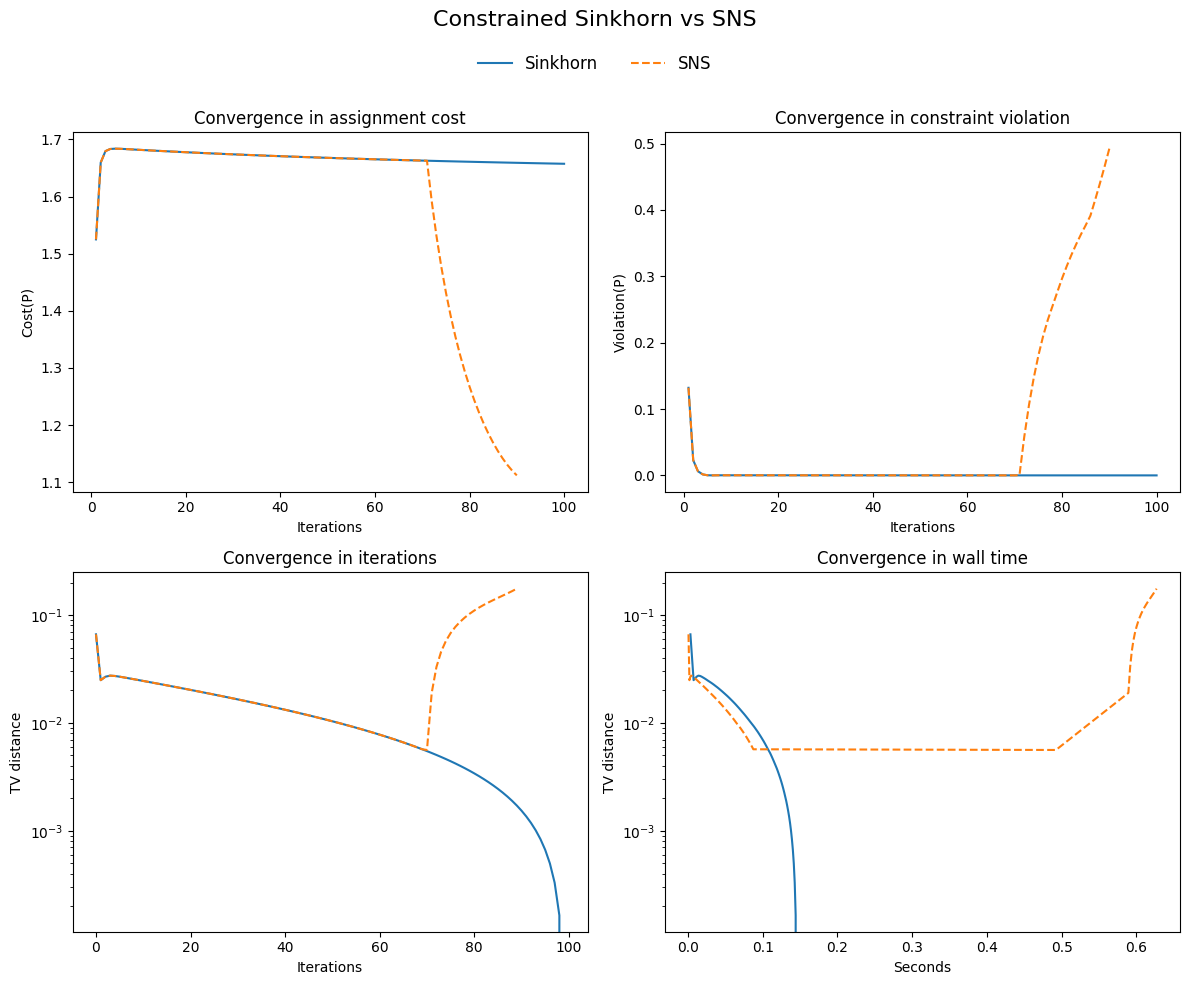

<Figure size 640x480 with 0 Axes>

In [19]:
rng = jax.random.key(0)
n=4
m=5
d=2
x, y = create_points(rng, n=n, m=m, d=d)
geom = pointcloud.PointCloud(x, y, epsilon=0.1)
C = geom.cost_matrix
D1 = jnp.ones((4,5))
D2 = 5*jnp.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=jnp.float32)
D_list = [D1, D2]
ineq_indices = [0]
eq_indices   = [1]
a = jnp.ones(n) / n
b = jnp.ones(m) / m
eta=1

_, _, _, it_sk, cost_sk, viol_sk, time_sk, Ps_sk = constrained_sinkhorn_ers(C, a, b, D_list=D_list, eq_indices=eq_indices, ineq_indices=ineq_indices, eta=eta, max_iter=100)
_, _, _, it_sns, cost_sns, viol_sns, time_sns, Ps_sns = sinkhorn_newton_sparse(C, a, b, D_list=D_list, eq_indices=eq_indices, ineq_indices=ineq_indices, eta=eta, max_iter_sinkhorn=70, max_iter_newton=20)

n, m = C.shape[0], C.shape[1]

P_ref = Ps_sk[-1]

def tv_distances(Ps, Pref):
    return np.array([0.5 * np.sum(np.abs(P - Pref)) for P in Ps])

tv_sk = tv_distances(Ps_sk, P_ref)
tv_sns = tv_distances(Ps_sns, P_ref)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))


axes[0,0].plot(it_sk, cost_sk, label='Sinkhorn')
axes[0,0].plot(it_sns, cost_sns, '--', label='SNS')
axes[0,0].set_xlabel("Iterations"); axes[0,0].set_ylabel("Cost(P)")
axes[0,0].set_title("Convergence in assignment cost")


axes[0,1].plot(it_sk, viol_sk, label='Sinkhorn')
axes[0,1].plot(it_sns, viol_sns, '--', label='SNS')
axes[0,1].set_xlabel("Iterations"); axes[0,1].set_ylabel("Violation(P)")
axes[0,1].set_title("Convergence in constraint violation")


axes[1,0].semilogy(range(len(tv_sk)), tv_sk, label='Sinkhorn')
axes[1,0].semilogy(range(len(tv_sns)), tv_sns, '--', label='SNS')
axes[1,0].set_xlabel("Iterations"); axes[1,0].set_ylabel("TV distance")
axes[1,0].set_title("Convergence in iterations")


axes[1,1].semilogy(time_sk, tv_sk, label='Sinkhorn')
axes[1,1].semilogy(time_sns, tv_sns, '--', label='SNS')
axes[1,1].set_xlabel("Seconds"); axes[1,1].set_ylabel("TV distance")
axes[1,1].set_title("Convergence in wall time")

fig.suptitle("Constrained Sinkhorn vs SNS", fontsize=16)

all_handles_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
handles = sum([hl[0] for hl in all_handles_labels], [])
labels  = sum([hl[1] for hl in all_handles_labels], [])

by_label = dict(zip(labels, handles))

fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='upper center',
    bbox_to_anchor=(0.5, 0.95),
    ncol=2,
    frameon=False,
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


plt.tight_layout()
plt.show()

<div style="
    border-left: 6px solid #1976d2;
    background-color: #e3f2fd;
    padding: 16px;
    border-radius: 6px;
    font-size: 15px;
    color: #212121;
    max-width: 100%;
    line-height: 1.6;
    word-wrap: break-word;
    box-sizing: border-box; /* Ajoutez cette ligne */
    overflow-wrap: break-word; /* Ajoutez cette ligne */
">

As soon as we switch from pure Sinkhorn to the Sinkhorn–Newton-Sparse stage, the TV distance actually increases instead of falling faster—both in terms of iteration count and wall-clock time. Rather than accelerating feasibility, the Newton step here is pushing us away from the marginal constraints. In fact, the particular linear constraints we imposed aren’t well-suited for a Newton correction.

</div>